<a href="https://colab.research.google.com/github/gmoraissc/Projetos_de_Data_Science/blob/main/Sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install emoji

     |████████████████████████████████| 174 kB 7.9 MB/s 
  Created wheel for emoji: filename=emoji-1.6.3-py3-none-any.whl size=170298 sha256=11b811c2c887cdab147fee59f13ece905d22db910d5c8946bd32383e15dbf383
  Stored in directory: /root/.cache/pip/wheels/03/8b/d7/ad579fbef83c287215c0caab60fb0ae0f30c4d7ce5f580eade
Successfully built emoji


In [ ]:
!pip install xlsxwriter

     |████████████████████████████████| 149 kB 8.6 MB/s 


In [ ]:
# imports
import pandas as pd
import numpy as np
import tweepy, nltk, json, os, csv, xlsxwriter, pytz, re
from pandas import ExcelWriter as ExcelWriter
from pathlib import Path
from datetime import datetime, date, timedelta
from csv import writer

In [ ]:
class auth_twitter(object):
  
  def __init__(self):
    pass

  def parametros_de_acesso(self, arquivo):
    
    self.arquivo = arquivo

    with open (arquivo, 'r') as arquivo:
      texto = arquivo.readlines()[0].split(',')
    
    access_token = texto[0].split('=')[1]
    access_token_secret = texto[1].split('=')[1]
    bearer_token = texto[2].split('=')[1]
    consumer_key = texto[3].split('=')[1]
    consumer_secret = texto[4].split('=')[1]

    arquivo.close()

    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)
    api = tweepy.API(auth, wait_on_rate_limit=True)
    
    return api

In [ ]:
api = auth_twitter().parametros_de_acesso('/content/drive/MyDrive/01.Instagram profissional/NLP/Sentiment Analysis/BBB22/Twitter/auth.txt')

In [ ]:
#d1 = date.today().strftime("%d/%m/%Y")
d1 = corrigir_timezone()

In [ ]:
class pesquisas_de_tweets(object):

  def __init__(self):
    pass

  def pesquisar_por_termo(self, query, result_type='recent', count=int(100)):
    
    global api

    self.query = query
    self.result_type = result_type
    self.count = count

    resultados_da_pesquisa = []

    for status in tweepy.Cursor(api.search,
                                q=self.query,
                                result_type=self.result_type,
                                count=self.count).items():
                                
                                resultados_da_pesquisa.append(status)

    return resultados_da_pesquisa, result_type
 
  def pesquisar_por_usuario(self, participante, result_type='recent', count=int(100)):
    
    global api, participantes_camarote, participantes_pipoca

    self.participante = participante
    self.result_type = result_type
    self.count = count
    
    tipo_participante = informacoes_de_participantes().checar_tipo_participante(participante)

    resultados_da_pesquisa = []

    for status in tweepy.Cursor(api.user_timeline,
                                screen_name=self.participante,
                                result_type=self.result_type,
                                exclude_replies=False).items(self.count):
                                
                                resultados_da_pesquisa.append(status)

    return resultados_da_pesquisa, result_type, tipo_participante

  def pesquisar_infos_usuario(self, screen_name):
  
    global api

    informacoes_hist_participante = []

    user_results = api.get_user(screen_name)

    utcmoment_naive = datetime.utcnow()
    utcmoment = utcmoment_naive.replace(tzinfo=pytz.utc)
    tz = 'America/Sao_Paulo'
    extracao = utcmoment.astimezone(pytz.timezone(tz)) - timedelta(hours=0, minutes=60)
    
    participante = user_results.name
    twitter = user_results.screen_name
    seguidores = user_results.followers_count
    seguindo = user_results.friends_count
    numero_de_listados = user_results.listed_count
    n_tweets_favoritados = user_results.favourites_count
    num_de_tweets_totais = user_results.statuses_count
    verificado = user_results.verified

    informacoes_hist_participante.append({'participante': str(participante),
                                          'twitter': str(twitter),
                                          'n_seguidores': int(seguidores),
                                          'n_seguindo': int(seguindo),
                                          'n_de_listados': int(numero_de_listados),
                                          'n_tweets_favoritados': int(n_tweets_favoritados),
                                          'num_de_tweets_totais': int(num_de_tweets_totais),
                                          'verificado': bool(verificado),
                                          'data': extracao})
    
    return informacoes_hist_participante

  def historico_infos(self, participantes):
  
    historico_info_participantes = []

    for participante in participantes:
      _ = self.pesquisar_infos_usuario(participante)
      historico_info_participantes.extend(_)
    
    return historico_info_participantes

In [191]:
class organizar_coletas_de_tweets(object):

  def __init__(self):
    pass

  def criar_dicionario_pesquisas(self, tweets_status, tipo):
      
    global d1

    self.tweets_status = tweets_status

    dicionario = {}

    for each_json_tweet in tweets_status:
      _ = json.dumps(each_json_tweet._json)
      
      if d1 not in dicionario.keys():
        tweet = {d1: [json.loads(_)]}
        dicionario.update(tweet)
        
      else:
        dicionario[d1].append(json.loads(_))
      
    return dicionario, tipo

  def criar_dataframe(self, dicionario, tipo_de_pesquisa):
    
    self.tipo_de_pesquisa = tipo_de_pesquisa

    lista = []

    for i in range(0, len(dicionario[d1])):

          tweet_id = dicionario[d1][i]['id']
          text = dicionario[d1][i]['text']
          favorite_count = dicionario[d1][i]['favorite_count']
          retweet_count = dicionario[d1][i]['retweet_count']
          created_at = dicionario[d1][i]['created_at']
          location = dicionario[d1][i]['user']['location']
          verified = dicionario[d1][i]['user']['verified']
          hashtags = dicionario[d1][i]['entities']['hashtags']
          user_mentions = dicionario[d1][i]['entities']['user_mentions']
          name = dicionario[d1][i]['user']['name']
          screen_name = dicionario[d1][i]['user']['screen_name']

          lista.append({'tweet_id': str(tweet_id),
                        'text': str(text),
                        'favorite_count': int(favorite_count),
                        'retweet_count': int(retweet_count),
                        'created_at': created_at,
                        'location': location,
                        'verified': verified,
                        'hashtags': hashtags,
                        'user_mentions': user_mentions,
                        'name': name,
                        'screen_name': screen_name})
          
    tweet_json_ = pd.DataFrame(lista, columns = 
                              ['tweet_id', 'text', 
                                'favorite_count', 'retweet_count', 
                                'created_at', 'location',
                                'verified', 'hashtags',
                                'user_mentions', 'name',
                                'screen_name'])
          
    tipo_participante = informacoes_de_participantes().checar_tipo_participante(screen_name)
          
    return tweet_json_, tipo_participante, tipo_de_pesquisa

  def salvar_csvs_no_diretorio(self, tipo_participante, tipo_pesquisa, dataframe):
    
    dir_csvs = f'/content/drive/MyDrive/01.Instagram profissional/NLP/Sentiment Analysis/BBB22/Twitter/DataFrames'
    data_extracao = corrigir_timezone()
    file_variable = dir_csvs + "/" + tipo_participante  + "/" + tipo_pesquisa + "/" + data_extracao
    file_name = tipo_participante[0:3] + "_" + tipo_pesquisa[0:3] + "_" + data_extracao + '.csv'
    file_path = file_variable + "/" + file_name

    if not os.path.exists(file_variable):
      os.makedirs(file_variable)
      dataframe.to_csv(file_path, index=False)

    else:
      with open(file_path, 'a') as f_object:
        writer_object = writer(f_object, delimiter=',')
        linhas = []
        
        for row in range(0, len(dataframe)):
          linhas.append([row for row in dataframe.iloc[row]])
          writer_object.writerow(linhas[row])

        f_object.close()

  def dataframe_dos_participantes(self, informacoes_hist_participante):

      self.informacoes_hist_participante = informacoes_hist_participante

      dados_participantes = pd.DataFrame(informacoes_hist_participante, columns = 
                                      ['participante', 'twitter', 'n_seguidores', 
                                      'n_seguindo','n_de_listados', 'n_tweets_favoritados',
                                      'num_de_tweets_totais', 'verificado', 'data'])
      
      return dados_participantes

  def salvar_historico(self, dataframe):
    
    dir_csvs = f'/content/drive/MyDrive/01.Instagram profissional/NLP/Sentiment Analysis/BBB22/Twitter/DataFrames/Participantes'
    data_extracao = corrigir_timezone()
    file_name = 'historico.csv'
    file_path = dir_csvs + "/" + file_name

    if not os.path.exists(dir_csvs):
      os.makedirs(dir_csvs)
      dataframe.to_csv(file_path, index=False)

    else:
      with open(file_path, 'a') as f_object:
        writer_object = writer(f_object, delimiter=',')
        linhas = []
        
        for row in range(0, len(dataframe)):
          linhas.append([row for row in dataframe.iloc[row]])
          writer_object.writerow(linhas[row])

        f_object.close()

In [ ]:
# metodo para adicionar termos mais relevantes para o modelo *publico e por participante, exemplo, memes
#termos mais frequentes para determinado participante

termos_de_pesquisa_BBB = ('BBB OR BBB22 OR BIG BROTHER BRASIL OR BIG BROTHER BRASIL 2022 OR OR #REDEBBB OR BIGBROTHER OR #BIGBROTHER OR #BBB OR #BBB22')

termos_de_pesquisa_participantes = {'Arthur': ['Arthur', 'Artur', 'Aguiar', 'Arthur Aguiar', '\u2747\ufe0f', '#TeamAguiar', '#TeamArthurAguiar'],
                                    'Naiara Azevedo': ['Naiara', 'Azevedo', '1f4b8', '#TeamNaiara', 'Nai', 'cantora'],
                                    'Pedro Scooby': ['Pedro', 'Scooby', '1f30a', '#TeamScooby', '#TimeScooby', '1f499'],
                                    'Brunna Gonçalves': ['Brunna', 'Gonçalves', '1f984', '#BBBRUNNA', 'BBBrunna', ''],
                                    'Paulo André': ['Paulo', 'André', '1f3c1', '#TeamPauloAndré', 'TeamPauloAndre'],
                                    'Maria': ['Maria', '1f40d	', '#TEAMMARIA', 'TIME MARIA', 'MARICONAS', ''],
                                    'Jade Picon': ['Jade', 'Picon', '1f32a\ufe0f', 'furacão', '#TeamJade', 'Picão', 'KdJade', 'Picões', 'Furacao'],
                                    'Douglas Silva': ['Douglas', 'Silva', '1f3b2', 'dado', 'dadinho',
                                    '#TeamDouglasSilva', '1f44a\U0001f3ff'],
                                    'Linn da Quebrada': ['Linn', 'Quebrada', '1f9dc\u200d\u2640\ufe0f', '1f9dc\U0001f3ff\u200d\u2640\ufe0f',
                                    '1f9dc\U0001f3fb\u200d\u2640\ufe0f', '1f9dc\U0001f3fe\u200d\u2640\ufe0f', '1f9dc\U0001f3fc\u200d\u2640\ufe0f',
                                    '1f9dc\U0001f3fd\u200d\u2640\ufe0f', '1f9dc', '1f9dc\U0001f3ff', '1f9dc\U0001f3fb', '1f9dc\U0001f3fe',
                                    '1f9dc\U0001f3fc', '1f9dc\U0001f3fd', '#TeamLinn', '#linndonas', '#LinnDonas'],
                                    'Tiago Abravanel': ['Tiago', 'Abravanel', '1f43b', '#TeamAbrava', '#TeamAbravanel', '1f9f8'],
                                    'Laís Caldas': ['Laís', 'Caldas', '1f462', '#TeamLais', '#TeamLaís', 'Time Lais', '1f49a'],
                                    'Luciano Estevan': ['Luciano', 'Estevan', '1f981', '#TeamLucianoEstevan', 'Lu', '1f346'],
                                    'Jessilane': ['Jessilane', '1f9ec', 'Jessi', '#TeamJessi', '#TimeJessi', '1f49c', 'Charmanders', ''],
                                    'Eliezer': ['Eliezer', '1F437', 'Eli', '#TeamEli', '1F953', '1F416', '1F43D'],
                                    'Eslovênia Marques': ['Eslovênia', 'Eslováquia', 'Marques', 'Eslô', '1f1f8\U0001f1ee',
                                                          'Time Eslo', 'Team Eslo', '#TimeEslô', '#TeamEslô',
                                                          'Eslovenia'],
                                    'Bábara Heck': ['Bárbara', 'Heck', '1f980', '#TeamBá', 'TeamBá', 'TimeBá',
                                                    'TimeBa', 'TeamBa', 'TeamBah', 'BBBah', 'Bá', 'Ba', '1f9a6'],
                                    'Rodrigo Mussi': ['Rodrigo Mussi', 'Mussi', 'Rodrigo', 'TEAM MUSSI', '#TeamMussi',
                                                      '#TimeMussi', '1f977\U0001f3ff', '1f977', '1f977\U0001f3fb',
                                                      '1f977\U0001f3fe', '1f977\U0001f3fc', '1f977\U0001f3fd', 'ninja', 'ninjas',
                                                      'TEAM NINJA', ''],
                                    'Natália Deodato': ['Natália', 'Deodato', '#TeamNaty', '#TimeNaty', 'Naty', 'vitilindos',
                                                        '1f483', '1f483\U0001f3ff', '1f483\U0001f3fb',
                                                        '1f483\U0001f3fe', '1f483\U0001f3fc',
                                                        '1f483\U0001f3fd'],
                                    'Vinicius': ['Vinicius', 'TeamVyni', '#TimeVyni', '#TeamVyni', '1f4a1'],
                                    'Lucas Bissoli': ['Lucas', 'Bissoli', '#TimeBissoli', '#TeamBissoli', 
                                                      '1f3c4\u200d\u2642\ufe0f', '1f3c4\U0001f3ff\u200d\u2642\ufe0f', 
                                                      '1f3c4\U0001f3fb\u200d\u2642\ufe0f', '1f3c4\U0001f3fe\u200d\u2642\ufe0f',
                                                      '1f3c4\U0001f3fc\u200d\u2642\ufe0f', '1f3c4\U0001f3fd\u200d\u2642\ufe0f',
                                                      '1f3c4', '1f3c4\U0001f3ff', '1f3c4\U0001f3fb', '1f3c4\U0001f3fe',
                                                      '1f3c4\U0001f3fc', '1f3c4\U0001f3fd', '1f3c4\u200d\u2640\ufe0f',
                                                      '1f3c4\U0001f3ff\u200d\u2640\ufe0f', '1f3c4\U0001f3fb\u200d\u2640\ufe0f',
                                                      '1f3c4\U0001f3fe\u200d\u2640\ufe0f', '1f3c4\U0001f3fc\u200d\u2640\ufe0f',
                                                      '1f3c4\U0001f3fd\u200d\u2640\ufe0f']}
                                    
dicionario_participantes = {'@Aguiarthur': 'Arthur Aguiar', 
                            '@Naiarazevedo': 'Naiara Azevedo',
                            '@PedroScooby': 'Pedro Scooby',
                            '@brunnagoncalves': 'Bruna Gonçalves',
                            '@iampauloandre': 'Paulo André',
                            '@eumaria': 'Maria',
                            '@jadepicon': 'Jade Picon',
                            '@Silva_DG': 'Douglas Silva',
                            '@linndaquebrada': 'Linn da Quebrada',
                            '@TiagoAbravanel': 'Tiago Abravanel',
                            '@Dra_laiscaldass': 'Laís Caldas',
                            '@LucianoEstevan': 'Luciano Estevan',
                            '@a_jessilane': 'Jessilane',
                            '@eusouoeli': 'Eliezer',
                            '@eslomarques': 'Eslovênia Maques',
                            '@bbaheck': 'Bábara Heck',
                            '@oficialmussi': 'Rodrigo Mussi',
                            '@oficial_deodato': 'Natália Deodato',
                            '@vyniof': 'Vinicius',
                            '@LucasBissoli_': 'Lucas Bissoli'}

participantes_camarote = ['Aguiarthur', 'Naiarazevedo', 'PedroScooby', 'brunnagoncalves', 
                          'iampauloandre', 'eumaria', 'jadepicon', 'Silva_DG', 'linndaquebrada', 'TiagoAbravanel']

participantes_pipoca = ['Dra_laiscaldass', 'LucianoEstevan', 'a_jessilane', 'Eli', 'eslomarques', 
                        'bbaheck', 'oficialmussi', 'oficial_deodato', 'vyniof', 'LucasBissoli_']

participantes_camarote_twitter = ['@Aguiarthur', '@Naiarazevedo', '@PedroScooby', '@brunnagoncalves', 
                          '@iampauloandre', '@eumaria', '@jadepicon', '@Silva_DG', '@linndaquebrada', '@TiagoAbravanel']

participantes_pipoca_twitter = ['@Dra_laiscaldass', '@LucianoEstevan', '@a_jessilane', '@eusouoeli', '@eslomarques', 
                        '@bbaheck', '@oficialmussi', '@oficial_deodato', '@vyniof', '@LucasBissoli_']

perfis_oficiais_bbb = ['bbb']

participantes_total = []
participantes_total.extend(participantes_pipoca)
participantes_total.extend(participantes_camarote)

In [ ]:
class informacoes_de_participantes(object):

  def __init__(self):
    pass

  @staticmethod
  def checar_tipo_participante(usuario):
      if usuario in participantes_camarote:
        return 'Camarote'
      elif usuario in participantes_pipoca:
        return 'Pipoca'
      elif usuario in perfis_oficiais_bbb:
        return 'PerfilOficial'
      else:
        return 'Publico'

In [ ]:
@abstractmethod
def corrigir_timezone():
  utcmoment_naive = datetime.utcnow()
  utcmoment = utcmoment_naive.replace(tzinfo=pytz.utc)
  tz = 'America/Sao_Paulo'
  extracao = utcmoment.astimezone(pytz.timezone(tz)) - timedelta(hours=0, minutes=60)
  data_de_extracao = extracao.date().strftime("%d%m%Y")

  return data_de_extracao

TESTES

PESQUISAS POR NOME DE USUARIO

In [ ]:
tweets, tipo_de_pesquisa, tipo_participante = pesquisas_de_tweets().pesquisar_por_usuario(participante='@PedroScooby', result_type='recent')
dicionario, tipo_de_pesquisa = organizar_coletas_de_tweets().criar_dicionario_pesquisas(tweets, tipo_de_pesquisa)
dataframe, tipo_participante, tipo_de_pesquisa = organizar_coletas_de_tweets().criar_dataframe(dicionario, tipo_de_pesquisa)
organizar_coletas_de_tweets().salvar_csvs_no_diretorio(tipo_participante, tipo_de_pesquisa, dataframe)

HISTÓRICO DOS PARTICIPANTES

In [193]:
organizar_coletas_de_tweets().salvar_historico(organizar_coletas_de_tweets().dataframe_dos_participantes(pesquisas_de_tweets().historico_infos(participantes_total)))

PESQUISA POR TERMO

In [ ]:
tweets, tipo_de_pesquisa = pesquisas_de_tweets().pesquisar_por_termo(query=termos_de_pesquisa_BBB)
dicionario, tipo_de_pesquisa = organizar_coletas_de_tweets().criar_dicionario_pesquisas(tweets, tipo_de_pesquisa)
dataframe, tipo_participante, tipo_de_pesquisa = organizar_coletas_de_tweets().criar_dataframe(dicionario, tipo_de_pesquisa)
#organizar_coletas_de_tweets().salvar_csvs_no_diretorio(tipo_participante, tipo_de_pesquisa, dataframe)

In [178]:
tweets, tipo_de_pesquisa, tipo_participante = pesquisas_de_tweets().pesquisar_por_usuario(participante='@bbb', result_type='recent')
dicionario, tipo_de_pesquisa = organizar_coletas_de_tweets().criar_dicionario_pesquisas(tweets, tipo_de_pesquisa)
dataframe, tipo_participante, tipo_de_pesquisa = organizar_coletas_de_tweets().criar_dataframe(dicionario, tipo_de_pesquisa)
#organizar_coletas_de_tweets().salvar_csvs_no_diretorio(tipo_participante, tipo_de_pesquisa, dataframe)

NOVAS FUNCIONALIDADES

In [ ]:
# em média, quantos seguidores ganha após um tweet positivo? e quantos perde após um tweet negativo?
# modelo de classificação baseado na popularidade do participante
# prob de ser eliminado no paredão de acordo com o atual nível de popularidade
# append no data frame para coletas automáticas!

VISUALIZAÇÕES GRÁFICAS

In [197]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [218]:
df = pd.read_csv(f'/content/drive/MyDrive/01.Instagram profissional/NLP/Sentiment Analysis/BBB22/Twitter/DataFrames/Participantes/historico.csv')
df['Data_ajustada'] = pd.to_datetime(df['data'], yearfirst=True, format='%y/%m/%d %H:%M:%S.%f')
df.head()

ValueError: ignored

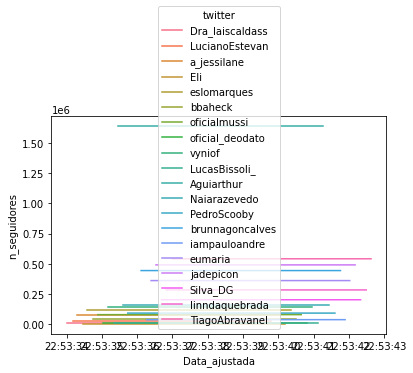

In [211]:
sns.lineplot(data=df,
             x='Data_ajustada',
             y='n_seguidores',
             hue='twitter')

NLP

In [ ]:
df = pd.read_csv(f'/content/drive/MyDrive/01.Instagram profissional/NLP/Sentiment Analysis/BBB22/Twitter/DataFrames/Camarote/recent/20012022/Cam_rec_20012022.csv')
df.head(3)

,tweet_id,text,favorite_count,retweet_count,created_at,location,verified,hashtags,user_mentions,name,screen_name
0,1484275264813252610,"""Se você votar em mim, cê pode ter certeza que...",13,54,Thu Jan 20 21:22:54 +0000 2022,"Goiânia, Brasil",True,[],[],Naiara Azevedo 💸,Naiarazevedo
1,1484285363799703553,Pessoa: a \nO Pedro: https://t.co/B601A7gp3J,1523,124,Thu Jan 20 22:03:02 +0000 2022,"Rio de Janeiro, Brasil",True,[],[],Pedro Scooby 🌊,PedroScooby
2,1484328856454455301,@shawnblod É sobre isso… 😂,3,0,Fri Jan 21 00:55:51 +0000 2022,"Rio de Janeiro, Brasil",True,[],"[{'screen_name': 'shawnblod', 'name': 'bia sco...",Pedro Scooby 🌊,PedroScooby


In [ ]:
calendar = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 
                'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
  
tweet_json['Week_day'] = tweet_json['created_at'].str.slice(0,3)
tweet_json['Month_name'] = tweet_json['created_at'].str.slice(4,7)
tweet_json['Month'] = tweet_json['Month_name'].map(calendar)
tweet_json['Day_number'] = tweet_json['created_at'].str.slice(8,10)
tweet_json['Tweeted_at_time'] = tweet_json['created_at'].str.slice(11,19)
tweet_json['Year'] = tweet_json['created_at'].str.slice(26,30)

NameError: ignored

In [ ]:
tweet_json['Data'] = str(str(tweet_json['Day_number']) + '-' + str(tweet_json['Month']) + '-' + str(tweet_json['Year']))

In [ ]:
tweet_json['Data'][0]

'0     15\n1     14\n2     14\n3     15\n4     14\n5     14\n6     15\n7     15\n8     14\n9     14\n10    15\n11    14\n12    14\n13    14\nName: Day_number, dtype: object-0     1\n1     1\n2     1\n3     1\n4     1\n5     1\n6     1\n7     1\n8     1\n9     1\n10    1\n11    1\n12    1\n13    1\nName: Month, dtype: int64-0     2022\n1     2022\n2     2022\n3     2022\n4     2022\n5     2022\n6     2022\n7     2022\n8     2022\n9     2022\n10    2022\n11    2022\n12    2022\n13    2022\nName: Year, dtype: object'

In [ ]:
pipocas_part.head(3)

,tweet_id,text,favorite_count,retweet_count,created_at,location,followers_count,friends_count,verified,hashtags,user_mentions,name,screen_name
0,1483265947175632897,@medracital ❤️,2,0,Tue Jan 18 02:32:14 +0000 2022,,3247,167,True,[],"[{'screen_name': 'medracital', 'name': 'lore 🇸...",Dra. Laís Caldas 👢,Dra_laiscaldass
1,1483265820528680961,@itscruella Pode encerrar viu? 😅🤍 https://t.co...,2,1,Tue Jan 18 02:31:44 +0000 2022,,3247,167,True,[],"[{'screen_name': 'itscruella', 'name': 'Cruell...",Dra. Laís Caldas 👢,Dra_laiscaldass
2,1483265480945287169,Contem pra gente.. o que estão achando da Laís...,125,9,Tue Jan 18 02:30:23 +0000 2022,,3247,167,True,"[{'text': 'TeamLais', 'indices': [74, 83]}, {'...",[],Dra. Laís Caldas 👢,Dra_laiscaldass


In [ ]:
word_tokenize(pipocas_part['text'])

NameError: ignored

In [ ]:
# ACOMPANHAR PAREDÕES, PROVAS, ETC (PESQUISAR PELO USUÁRIO OFICIAL DO BBBB)
tweets, tipo_de_pesquisa, tipo_participante = pesquisas_de_tweets().pesquisar_por_usuario(participante='@bbb', result_type='recent')
dicionario, tipo_de_pesquisa = organizar_coletas_de_tweets().criar_dicionario_pesquisas(tweets, tipo_de_pesquisa)
dataframe, tipo_participante, tipo_de_pesquisa = organizar_coletas_de_tweets().criar_dataframe(dicionario, tipo_de_pesquisa)
organizar_coletas_de_tweets().salvar_csvs_no_diretorio(tipo_participante, tipo_de_pesquisa, dataframe)

In [ ]:
tweet_json_recents.join(tweet_json_popular, on='tweet_id')

ValueError: ignored